<a href="https://colab.research.google.com/github/vk59/AI-minor-ML/blob/hw1_hw2_hw3/MLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 1

In [131]:
import pandas as pd
import numpy as np

## Бизнес-постановка задачи
Компания работает с большим числом сотрудников и большую ставку делает именно на качество их работы. Однако с каждым случаются неприятности, возникает психологическая усталость, особенно в пост-ковидное время. В компании есть штатные психологи, но к ним всегда огромная очередь, запись на несколько месяцев вперед. Компания решила нанять еще одну группу резервных психологов для выгорающих людей. Нужно понять, какие из сотрудников более всего выгорают в настоящее время на основе данных за предыдущие годы.

## Постановка задачи ML
Предсказать, какие сейчас сотрудники скорее всего выгорели на основании данных из внутренних опросов компании и сбора данных от руководителей. На основании этого предпринимать точечные действия на местах

## Метрики


Для оценки качества модели была использована метрика ROC AUC, которая является независимой от конкретной модели и баланса классов в выборке. Эта метрика обеспечивает простой способ сравнения различных моделей: чем выше значение ROC AUC, тем лучше качество модели.

## EDA

In [132]:
burn_out = pd.read_csv("train.csv")
display(burn_out.head())
burn_out.shape

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


(22750, 9)

Датасет содержит около 23к строк и 9 столбцов:
- `Employee ID`: Уникальный идентификатор сотрудника (пример: fffe390032003000)
- `Date of Joining`: Дата трудоустройства (пример: 2008-12-30)
- `Gender`: Пол сотрудника (Male/Female)
- `Company Type`: Тип компании (Service/Product)
- `WFH Setup Available`: Есть ли возможность работать из дома (Yes/No)
- `Designation`: Статус сотрудника в диапазоне от 0 до 5.
- `Resource Allocation`: Количество рабочих часов от 1 до 10.
- `Mental Fatigue Score`: Уровень психологической усталости от 0 до 10.
- `Burn Rate`: Степень выгорания сотрудника от 0 до 1.

## Анализ колонок

Целевой переменной является `Burn Rate`. Это вещественное число, его нужно перевести в бинарный признак

Проверим, есть в ли данных какие-либо пропуски.

In [133]:
burn_out.isnull().any()

Employee ID             False
Date of Joining         False
Gender                  False
Company Type            False
WFH Setup Available     False
Designation             False
Resource Allocation      True
Mental Fatigue Score     True
Burn Rate                True
dtype: bool

Такие значения есть. Параметров для обучения достаточно мало, поэтому если мы будем дропать колонки, то потеряем значительную часть бесценных данных. В рамках обучения дропнем строки, в которых отсутствуют `Burn Rate`, а в `Resource Allocation` и `Mental Fatigue Score` подставим средние значения из этих колонок

In [134]:
burn_out = burn_out[burn_out['Burn Rate'].notna()]
burn_out.shape

(21626, 9)

Потеря данных незначительна, так и оставим

Стоит убрать айдишники сотрудников - они для обучения ни к чему

In [135]:
burn_out = burn_out.drop(columns=['Employee ID'])
burn_out

,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52
...,...,...,...,...,...,...,...,...
22745,2008-12-30,Female,Service,No,1.0,3.0,NaN,0.41
22746,2008-01-19,Female,Product,Yes,3.0,6.0,6.7,0.59
22747,2008-11-05,Male,Service,Yes,3.0,7.0,NaN,0.72
22748,2008-01-10,Female,Service,No,2.0,5.0,5.9,0.52


## Визуальный анализ

Посмотрим на значения из столбца `Burn Rate`

In [136]:
burn_out['Burn Rate'].mean()

0.45200545639508

In [137]:
burn_out['Burn Rate'].max()

1.0

In [138]:
burn_out['Burn Rate'].min()

0.0

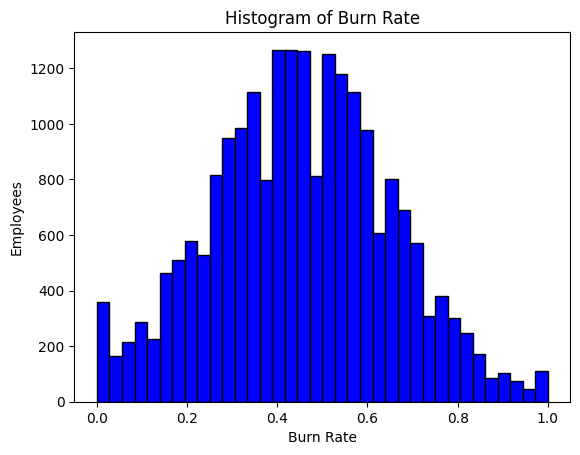

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

def hist(column_name):
  # matplotlib histogram
  plt.hist(burn_out[column_name], color = 'blue', edgecolor = 'black',
          bins = int(180/5))
  # Add labels
  plt.title('Histogram of {}'.format(column_name))
  plt.xlabel(column_name)
  plt.ylabel('Employees')

hist('Burn Rate')

Компания понимает, что всем сотрудникам помочь не сможет. На уровне HR-менеджмента компания приняла решение, что будет считать самыми выгоревшеми сотрудников с Burn Rate >= `0.8`. Здесь и далее мы заменим переменную Burn Rate на бинарную переменную `Burned out` со значениями `True`/`False`

In [140]:
def binary_burn(rate):
  if rate < 0.8:
    return False
  else:
    return True
burn_out['Burned out'] = burn_out['Burn Rate'].map(binary_burn)
burn_out.head()

,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Burned out
0,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16,False
1,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36,False
2,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49,False
3,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20,False
4,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52,False


In [141]:
def bar(column_name):
  plt.title('Bar of {}'.format(column_name))
  plt.xlabel(column_name)
  plt.ylabel('Employees')
  counts = burn_out[column_name].value_counts()
  plt.bar(counts.index, counts.values)

Для обучения также будем использовать не дату присоединения человека в компанию, а количество дней работы

In [142]:
real_date = datetime.strptime('2008-05-20', "%Y-%m-%d").date()
(date(2020, 5, 20) - real_date).days

4383

In [143]:
from datetime import date
from datetime import datetime
def work_time(date_of_join):
  real_date = datetime.strptime(date_of_join, "%Y-%m-%d").date()
  return (date(2020, 5, 20) - real_date).days

burn_out['Work time'] = burn_out['Date of Joining'].map(work_time)
burn_out = burn_out.drop(columns=['Date of Joining'])
burn_out.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Burned out,Work time
0,Female,Service,No,2.0,3.0,3.8,0.16,False,4250
1,Male,Service,Yes,1.0,2.0,5.0,0.36,False,4189
2,Female,Product,Yes,2.0,NaN,5.8,0.49,False,4454
3,Male,Service,Yes,1.0,1.0,2.6,0.20,False,4216
4,Female,Service,No,3.0,7.0,6.9,0.52,False,4318


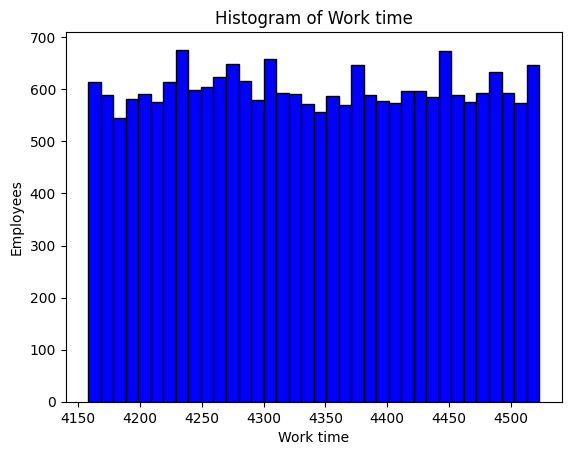

In [144]:
hist('Work time')

Все сотрудники пришли примерно в одно и то же время в компанию. Возможно, этот параметр не будет играть роли при обучении.

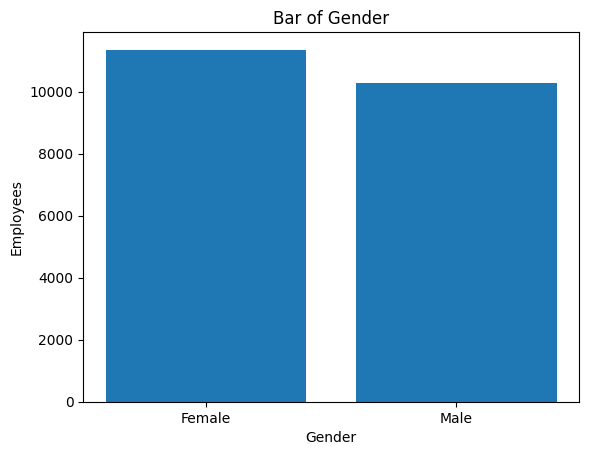

In [145]:
bar('Gender')

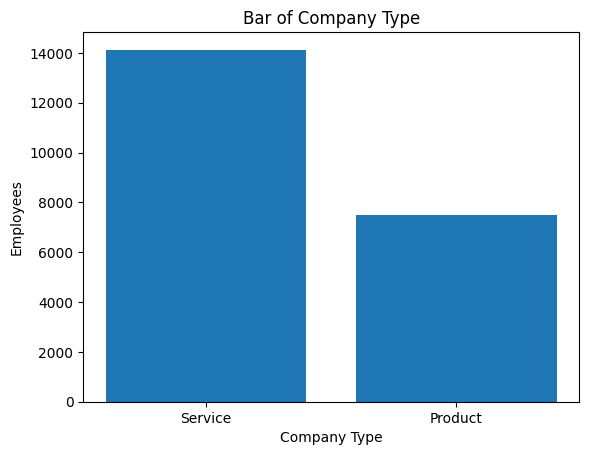

In [146]:
bar('Company Type')

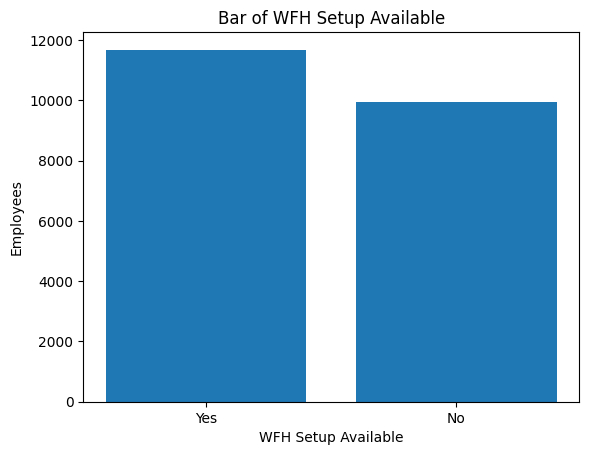

In [147]:
bar('WFH Setup Available')

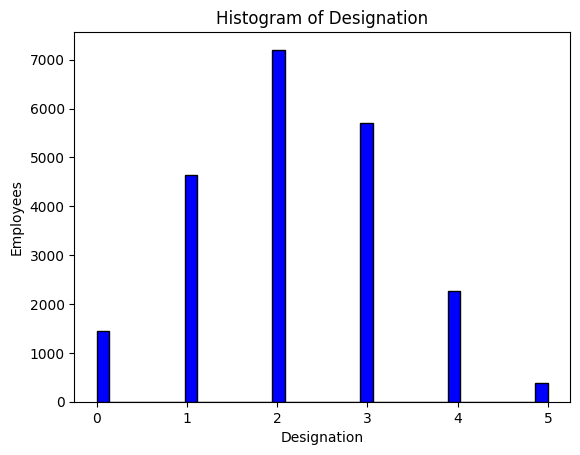

In [148]:
hist('Designation')

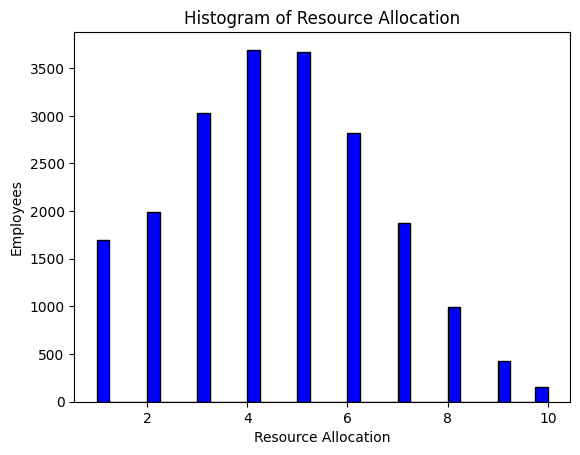

In [149]:
hist('Resource Allocation')

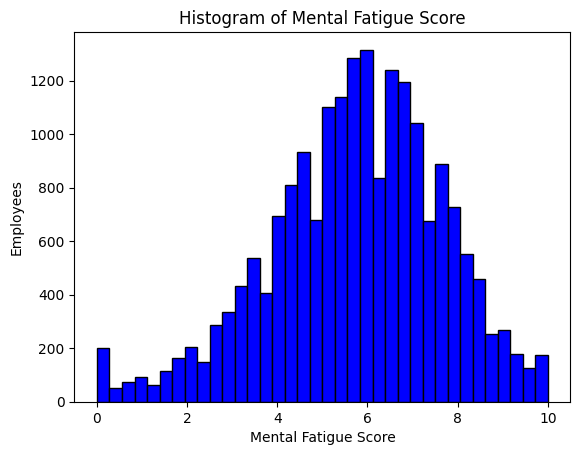

In [150]:
hist('Mental Fatigue Score')

# ДЗ 2

## Преобразования данных

Посмотрим еще раз на данные

In [151]:
burn_out.dtypes

Gender                   object
Company Type             object
WFH Setup Available      object
Designation             float64
Resource Allocation     float64
Mental Fatigue Score    float64
Burn Rate               float64
Burned out                 bool
Work time                 int64
dtype: object

Здесь
- Burn Rate нам больше не понадобится,
- WFH Setup Available можно перевести в True/False,
- Company Type можно перевести в числовые значения 0 (Product) и 1 (Service)
- Gender можно перевести в числовые значения 0 (Female), 1 (Male)
- Возможно, параметр Work time не будет влиять на модель, но его оставим, поскольку не уверены в этом

In [152]:
def wfh_cat(text):
  if text == 'Yes':
    return True
  else:
    return False
burn_out['WFH Setup Available_cat'] = burn_out['WFH Setup Available'].map(wfh_cat)
burn_out['Gender'] = burn_out['Gender'].astype('category')
burn_out['Gender_cat'] = burn_out['Gender'].cat.codes
burn_out['Company Type'] = burn_out['Company Type'].astype('category')
burn_out['Company Type_cat'] = burn_out['Company Type'].cat.codes
burn_out.head()

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Burned out,Work time,WFH Setup Available_cat,Gender_cat,Company Type_cat
0,Female,Service,No,2.0,3.0,3.8,0.16,False,4250,False,0,1
1,Male,Service,Yes,1.0,2.0,5.0,0.36,False,4189,True,1,1
2,Female,Product,Yes,2.0,NaN,5.8,0.49,False,4454,True,0,0
3,Male,Service,Yes,1.0,1.0,2.6,0.20,False,4216,True,1,1
4,Female,Service,No,3.0,7.0,6.9,0.52,False,4318,False,0,1


Дропнем ненужные колонки

In [153]:
burn_out = burn_out.drop(columns=['Company Type', 'WFH Setup Available', 'Gender', 'Burn Rate'])
burn_out.head()

,Designation,Resource Allocation,Mental Fatigue Score,Burned out,Work time,WFH Setup Available_cat,Gender_cat,Company Type_cat
0,2.0,3.0,3.8,False,4250,False,0,1
1,1.0,2.0,5.0,False,4189,True,1,1
2,2.0,NaN,5.8,False,4454,True,0,0
3,1.0,1.0,2.6,False,4216,True,1,1
4,3.0,7.0,6.9,False,4318,False,0,1


Теперь нужно заполнить пропуски. Посмотрим, где они вообще есть

In [154]:
burn_out.isnull().any()

Designation                False
Resource Allocation         True
Mental Fatigue Score        True
Burned out                 False
Work time                  False
WFH Setup Available_cat    False
Gender_cat                 False
Company Type_cat           False
dtype: bool

Это занятость и рейтинг психологической усталости.

Их можно заполнить средними значениями без потери качества

In [155]:
burn_out['Resource Allocation'].fillna(int(burn_out['Resource Allocation'].mean()),inplace=True)
burn_out['Mental Fatigue Score'].fillna(burn_out['Mental Fatigue Score'].mean(),inplace=True)
burn_out.isnull().any()

Designation                False
Resource Allocation        False
Mental Fatigue Score       False
Burned out                 False
Work time                  False
WFH Setup Available_cat    False
Gender_cat                 False
Company Type_cat           False
dtype: bool

Порядок! Разделим данные на тестовую и тренировочную выборки

In [157]:
from sklearn. model_selection import train_test_split
df_train, df_test = train_test_split(burn_out, test_size=0.2, random_state=42)

y_train = df_train['Burned out']
X_train = df_train.drop(['Burned out'], axis=1)
y_test = df_test['Burned out']
X_test = df_test.drop(['Burned out'], axis=1)

## Обучение моделей

### kNN

In [158]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

k = 5
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.8950270469293291


Очень неплохо! Но вдруг мы можем лучше, поигравшись с параметром k?

In [163]:
def knn(k):
  m = KNeighborsClassifier(n_neighbors=k)
  m.fit(X_train, y_train)

  print("k=" + str(k) + " " + str(roc_auc_score(y_test, m.predict_proba(X_test)[:, 1])))

for i in range(3, 13):
  knn(i)

k=3 0.8650588000797289
k=4 0.8870057083693222
k=5 0.8950270469293291
k=6 0.9089664584855935
k=7 0.9110538059486635
k=8 0.9210808251943392
k=9 0.9229328616038801
k=10 0.9284882787411689
k=11 0.9278674728146524
k=12 0.9273650145062342


Оптимальное значение k=10, далее модель уже показывает худший результат

### Random Forest

In [166]:
from sklearn.ensemble import RandomForestClassifier

def forest(n):
  m = RandomForestClassifier(n_estimators=n, random_state=42)
  m.fit(X_train, y_train)

  print("n=" + str(n) + " " + str(roc_auc_score(y_test, m.predict_proba(X_test)[:, 1])))

forest(1000)

n=1000 0.9831012058999401


0.98 - это лучший результат, чем в kNN

In [167]:
forest(500)

n=500 0.983194638230018


В какой-то момент лес переобучился, нужно проверить самую оптимальную глубину, она точно меньше 1000

In [168]:
for i in range(300, 700, 100):
  forest(i)

n=300 0.9806249031072132
n=400 0.9832500055367307
n=500 0.983194638230018
n=600 0.9831378867406374


При n ~400 мы получаем наиболее хороший результат. Очевидно, при увеличении этого параметра дальше, модель переобучается.

### Логистическая регрессия


In [169]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='saga', max_iter=10000, random_state=42)
model.fit(X_train, y_train)

print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.9688067514893806


Чуть хуже, чем дерево, но всё ещё лучше, чем kNN.

### Выводы
Мы получили отличный результат обучения. Но тут стоит обратить внимание на то, что некоторые параметры могут слишком сильно влиять на результат обучения. Например, уровень психологической усталости, который отмечают сотрудники.

# ДЗ 3

В качастве сложной модели я выбрал градиентный бустинг на деревьях.
- в предыдущей работе деревья уже показали себя отличным образом
- композиции решающих деревьев являются эффективным выбором для таких типов данных.

In [172]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.7 MB/s eta 0:00:00


In [173]:
from catboost import CatBoostClassifier

cat_features = ['Gender_cat', 'WFH Setup Available_cat', 'Company Type_cat']

model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, logging_level='Silent', random_seed=42)
model.fit(X_train, y_train, cat_features=cat_features)

print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

ROC AUC: 0.9851968584590172


Вау! Нам удалось достичь почти 99% точности! Подберем гиперпараметры

In [175]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

model = CatBoostClassifier(logging_level='Silent', random_seed=42)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'iterations': [300, 400, 500],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc')
grid_search.fit(X_train, y_train, cat_features=cat_features)

print("Лучшие гиперпараметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
print("ROC AUC:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

Лучшие гиперпараметры: {'depth': 6, 'iterations': 500, 'learning_rate': 0.01}
ROC AUC: 0.9900581079883951


Мы пробили заветную точку в 99% точности! Теперь наша модель достаточно точно может предсказать, выгорел сотрудник или нет.

Посмотрим теперь на значимость признаков

## Значимость признаков

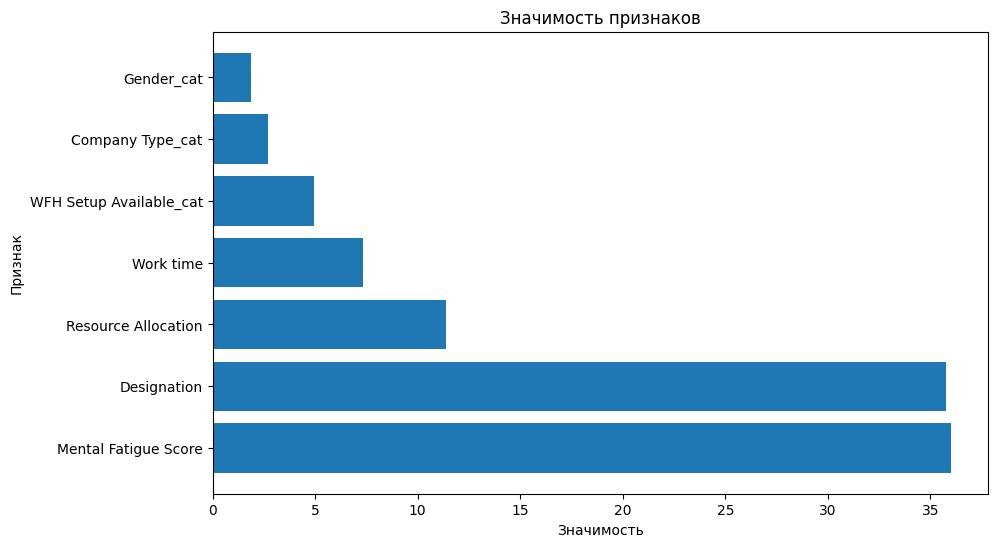

In [177]:
importance_df = pd.DataFrame({'Признак': X_train.columns, 'Значимость': best_model.feature_importances_})
importance_df = importance_df.sort_values(by='Значимость', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Признак'], importance_df['Значимость'])
plt.xlabel('Значимость')
plt.ylabel('Признак')
plt.title('Значимость признаков')
plt.show()

**Из диаграммы выше можно сделать незамысловатые инсайты**:
- на нашу модель сильнее всего влияет психологическая усталость сотрудника (оно и логично - если сотрудник чувствует, что выгорает и отмечает психологическую усталость, он скорее всего нуждается в помощи),
- должность так же очень влияет на результаты модели - здесь нужно дополнительное исследование, на каких позициях люди выгорают больше. Возможно, проблема комплексная и компании нужно поменять подход к организации работы сотрудников
- с огромным отрывом находятся время работы в компании и занятость сотрудников. С занятостью сотрудников так же можно работать
- мужчины и женщины очень слабо различаются в риске выгорания, однако вклад этих признаков ненулевой, так что можно провести дополнительные исследования о том, насколько каждый из полов подвержен риску.
- аналогично проверить тип компании и возможность работы из дома - возможно, этими средствами можно снизить часть выгораний (например, если гипотеза, что люди из дома чувствуют себя хуже, предложить им работать из офиса и наоборот)

## Общие выводы

Мы неплохо поработали с данными о сотрудниках нашей компании и совершенно точно знаем о них больше. Мы знаем, с чем можно работать для повышения самочувствия сотрудников
- попробовать новый формат работы
- давать людям разнообразные задачи (продуктовые и сервисные)
- психологам необходимо работать с сотрудниками на высоких должностях
- регулярно проводить такие исследования внутри компании для оценки выгорания сотрудников